In [4]:
#importing necessary libraries

import numpy as np
from numpy import expand_dims
import pandas as pd
import seaborn as sns
import tensorflow
import keras
import os
import glob
from skimage import io
import skimage
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import random
import matplotlib.pyplot as plt
import cv2
from keras_preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
import math

In [5]:
# Loading training and testing data from image/data folder
# Try both 'data' and 'Data' folder names
import os

# First, check for fer2013.csv which typically has Usage column (Training/PublicTest/PrivateTest)
fer2013_paths = ['fer2013.csv', 'data/fer2013.csv', 'Data/fer2013.csv']
fer2013_path = None
for path in fer2013_paths:
    if os.path.exists(path):
        fer2013_path = path
        break

if fer2013_path:
    print(f"Found fer2013.csv at: {fer2013_path}")
    fer2013 = pd.read_csv(fer2013_path)
    print("fer2013.csv columns:", fer2013.columns.tolist())
    print("fer2013.csv shape:", fer2013.shape)
    
    # Check if it has Usage column
    if 'Usage' in fer2013.columns:
        print("\nfer2013.csv has 'Usage' column - extracting train/test split")
        print("Usage values:", fer2013['Usage'].unique())
        
        # Extract training data
        train = fer2013[fer2013['Usage'] == 'Training'].copy()
        # Extract test data (combine PublicTest and PrivateTest)
        test = fer2013[fer2013['Usage'].isin(['PublicTest', 'PrivateTest'])].copy()
        
        print(f"\nTraining data from fer2013: {train.shape}")
        print(f"Test data from fer2013: {test.shape}")
        print(f"Test data has 'emotion' column: {'emotion' in test.columns}")
        has_test_labels = 'emotion' in test.columns
        
        # Drop Usage column as we don't need it anymore
        if 'Usage' in train.columns:
            train = train.drop('Usage', axis=1)
        if 'Usage' in test.columns:
            test = test.drop('Usage', axis=1)
    else:
        print("fer2013.csv doesn't have 'Usage' column, trying separate train/test files")
        fer2013_path = None

# If no fer2013.csv or it doesn't have Usage, try separate files
if fer2013_path is None:
    data_paths = ['data/train.csv', 'Data/train.csv']
    train_path = None
    for path in data_paths:
        if os.path.exists(path):
            train_path = path
            break

    if train_path is None:
        raise FileNotFoundError("Could not find train.csv or fer2013.csv in 'data/' or 'Data/' folder")

    # Load training data
    train = pd.read_csv(train_path)
    print("\nTraining data shape:", train.shape)
    print("Training data columns:", train.columns.tolist())
    print("\nFirst few rows:")
    print(train.head())

    # Check if 'emotion' column exists
    if 'emotion' not in train.columns:
        raise KeyError(f"'emotion' column not found in train.csv. Available columns: {train.columns.tolist()}")

    # Check if test.csv exists
    test_paths = ['data/test.csv', 'Data/test.csv']
    test_path = None
    for path in test_paths:
        if os.path.exists(path):
            test_path = path
            break

    if test_path:
        test = pd.read_csv(test_path)
        print("\nTest data shape:", test.shape)
        print("Test data columns:", test.columns.tolist())
        print("\nFirst few rows of test:")
        print(test.head())
        # Test.csv might not have 'emotion' column (it's often unlabeled)
        has_test_labels = 'emotion' in test.columns
        print(f"Test data has labels: {has_test_labels}")
        
        # If test.csv has no labels, try to match pixels with train.csv to find emotions
        if not has_test_labels:
            print("\nAttempting to match test.csv pixels with train.csv to find emotions...")
            # Create a mapping from pixels to emotion in training data
            train_pixel_to_emotion = dict(zip(train['pixels'], train['emotion']))
            # Try to match test pixels
            test['emotion'] = test['pixels'].map(train_pixel_to_emotion)
            matched_count = test['emotion'].notna().sum()
            print(f"Matched {matched_count} out of {len(test)} test samples with training data")
            
            if matched_count > 0:
                # Keep only matched rows
                test = test[test['emotion'].notna()].copy()
                test['emotion'] = test['emotion'].astype(int)
                has_test_labels = True
                print(f"Using {len(test)} test samples with matched emotions")
            else:
                print("Could not match test pixels with training data")
    else:
        print("\nNo test.csv found")
        test = None
        has_test_labels = False

# Check unique emotion classes
unique_emotions = sorted(train['emotion'].unique())
print(f"\nUnique emotion classes: {unique_emotions}")
print(f"Number of classes: {len(unique_emotions)}")

# Limit to maximum 5 classes by removing classes with MOST images (to balance dataset)
max_classes = 5
if len(unique_emotions) > max_classes:
    print(f"\nLimiting dataset to {max_classes} classes...")
    
    # Count images per class
    class_counts = train['emotion'].value_counts().sort_values(ascending=False)
    print("\nClass distribution (before limiting):")
    emotion_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    for emotion_id, count in class_counts.items():
        print(f"  Class {emotion_id} ({emotion_names.get(emotion_id, 'Unknown')}): {count} images")
    
    # Remove the classes with the MOST images (to balance dataset)
    num_to_remove = len(unique_emotions) - max_classes
    classes_to_remove = class_counts.head(num_to_remove).index.tolist()
    classes_to_keep = [e for e in unique_emotions if e not in classes_to_remove]
    
    print(f"\nRemoving {num_to_remove} classes with MOST images:")
    for cls in classes_to_remove:
        print(f"  - Class {cls} ({emotion_names.get(cls, 'Unknown')}): {class_counts[cls]} images")
    
    print(f"\nKeeping {max_classes} classes:")
    for cls in classes_to_keep:
        print(f"  - Class {cls} ({emotion_names.get(cls, 'Unknown')}): {class_counts[cls]} images")
    
    # Filter dataset to keep only selected classes
    train = train[train['emotion'].isin(classes_to_keep)]
    if test is not None and has_test_labels:
        test = test[test['emotion'].isin(classes_to_keep)]
    
    unique_emotions = sorted(train['emotion'].unique())
    print(f"\nFinal classes used: {unique_emotions}")
    print(f"Final training samples: {len(train)}")
else:
    print(f"\nDataset has {len(unique_emotions)} classes (≤ {max_classes})")

Found fer2013.csv at: data/fer2013.csv
fer2013.csv columns: ['emotion', 'pixels', 'Usage']
fer2013.csv shape: (35887, 3)

fer2013.csv has 'Usage' column - extracting train/test split
Usage values: ['Training' 'PublicTest' 'PrivateTest']

Training data from fer2013: (28709, 3)
Test data from fer2013: (7178, 3)
Test data has 'emotion' column: True

Unique emotion classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Number of classes: 7

Limiting dataset to 5 classes...

Class distribution (before limiting):
  Class 3 (Happy): 7215 images
  Class 6 (Neutral): 4965 images
  Class 4 (Sad): 4830 images
  Class 2 (Fear): 4097 images
  Class 0 (Angry): 3995 images
  Class 5 (Surprise): 3171 images
  Class 1 (Disgust): 436 images

Removing 2 classes with MOST images:
  - Class 3 (Happy): 7215 images
  - Class 6 (Neutral): 4965 images

Keeping 5 classes:
  - Class 0 (Angry): 3995 images
  - Class 1 (Disgust): 436 images
  - Class 2 (Fear): 4097 ima

In [7]:
# Check label distribution in training data
print("Training label counts:")
print(train['emotion'].value_counts().sort_index())

Training label counts:
emotion
0    3995
1     436
2    4097
4    4830
5    3171
Name: count, dtype: int64


In [8]:
# If test data exists, check its label distribution
if test is not None:
    if 'emotion' in test.columns:
        print("Test label counts:")
        print(test['emotion'].value_counts().sort_index())
    else:
        print("Test data exists but has no 'emotion' column (unlabeled test set)")
        print("Test data will be split from training data for evaluation")
else:
    print("Test data will be split from training data")

Test label counts:
emotion
0     958
1     111
2    1024
4    1247
5     831
Name: count, dtype: int64


In [10]:
# Assign features and targets for downstream steps
Y_train = train['emotion'].values
X_train_pixels = train['pixels']

if test is not None and has_test_labels:
    # Test data has labels
    Y_test = test['emotion'].values
    X_test_pixels = test['pixels']
elif test is not None:
    # Test data exists but has no labels - we'll need to split training data for evaluation
    print("Warning: test.csv has no 'emotion' column. Splitting training data for evaluation.")
    from sklearn.model_selection import train_test_split
    train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify=train['emotion'])
    Y_train = train_split['emotion'].values
    Y_test = test_split['emotion'].values
    X_train_pixels = train_split['pixels']
    X_test_pixels = test_split['pixels']
else:
    # No test.csv exists - split training data
    from sklearn.model_selection import train_test_split
    train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify=train['emotion'])
    Y_train = train_split['emotion'].values
    Y_test = test_split['emotion'].values
    X_train_pixels = train_split['pixels']
    X_test_pixels = test_split['pixels']

print("X_train_pixels shape:", X_train_pixels.shape)
print("X_test_pixels shape:", X_test_pixels.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Type of X_train_pixels:", type(X_train_pixels))
print("Type of Y_train:", type(Y_train))

X_train_pixels shape: (16529,)
X_test_pixels shape: (4171,)
Y_train shape: (16529,)
Y_test shape: (4171,)
Type of X_train_pixels: <class 'pandas.core.series.Series'>
Type of Y_train: <class 'numpy.ndarray'>


In [11]:
# Check for null/NaN values in labels (Y_train and Y_test are numpy arrays)
print("Y_train null count:", np.isnan(Y_train).sum() if Y_train.dtype == np.float64 else 0)
print("Y_test null count:", np.isnan(Y_test).sum() if Y_test.dtype == np.float64 else 0)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_train unique values:", np.unique(Y_train))
print("Y_test unique values:", np.unique(Y_test))

Y_train null count: 0
Y_test null count: 0
Y_train shape: (16529,)
Y_test shape: (4171,)
Y_train unique values: [0 1 2 4 5]
Y_test unique values: [0 1 2 4 5]


In [12]:
# Convert the space-separated pixel strings to numeric arrays (48x48 images)
def pixels_to_array(pixel_string, img_size=(48, 48)):
    """Convert space-separated pixel string to numpy array."""
    pixels = np.array(pixel_string.split(), dtype='float32')
    return pixels.reshape(img_size)

X_train_arr = np.array([pixels_to_array(img) for img in X_train_pixels])
X_test_arr  = np.array([pixels_to_array(img) for img in X_test_pixels])

print("X_train_arr shape:", X_train_arr.shape)
print("X_test_arr shape:", X_test_arr.shape)
print("Type:", type(X_train_arr))
print("Pixel value range:", X_train_arr.min(), "to", X_train_arr.max())


X_train_arr shape: (16529, 48, 48)
X_test_arr shape: (4171, 48, 48)
Type: <class 'numpy.ndarray'>
Pixel value range: 0.0 to 255.0


In [13]:
# Data already has shape (n_samples, height, width) - 48x48 images
X_train_unflattened = X_train_arr  # Already in correct shape
X_test_unflattened = X_test_arr    # Already in correct shape

print("X_train_unflattened shape:", X_train_unflattened.shape)
print("X_test_unflattened shape:", X_test_unflattened.shape)

X_train_unflattened shape: (16529, 48, 48)
X_test_unflattened shape: (4171, 48, 48)


0 255


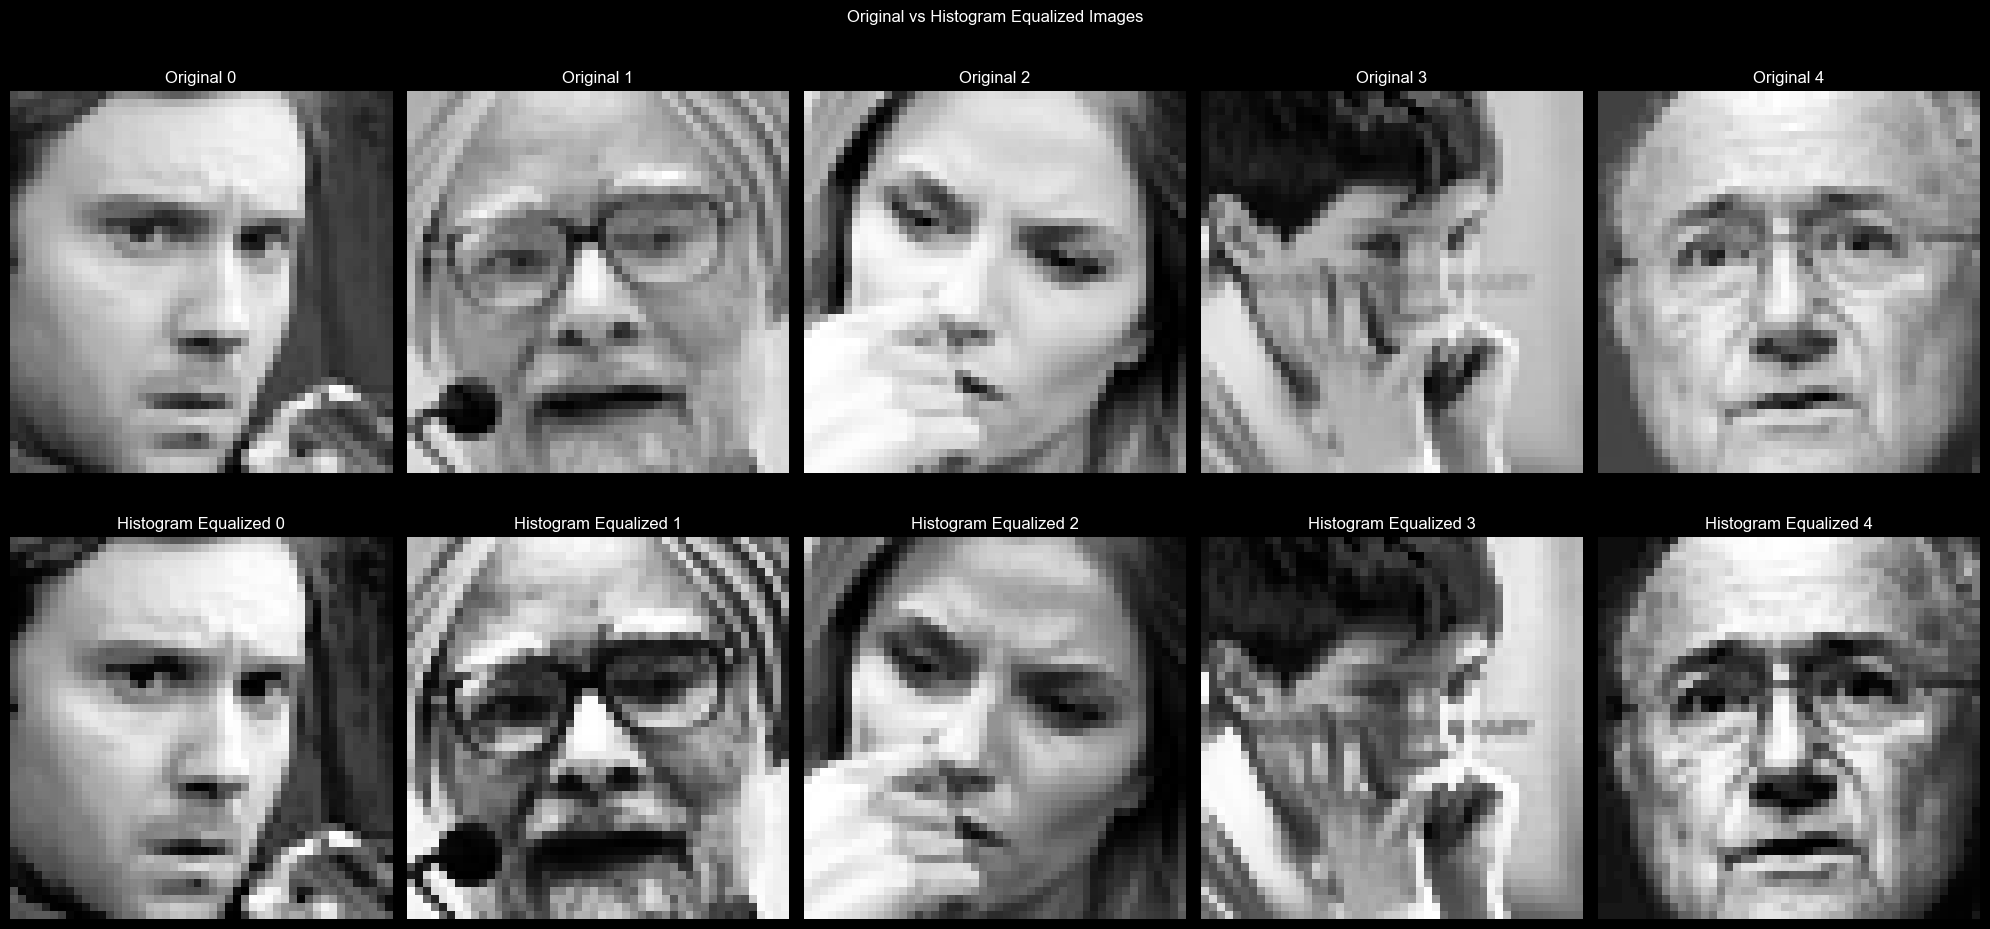

In [14]:
# Histogram Equalization (replacing CLAHE)
X_train_uint8 = X_train_unflattened.astype(np.uint8)
X_test_uint8 = X_test_unflattened.astype(np.uint8)

# Apply Histogram Equalization to every image
X_train_clahe = np.array([cv2.equalizeHist(img) for img in X_train_uint8], dtype=np.uint8)

# Similarly, for test set if needed
X_test_clahe = np.array([cv2.equalizeHist(img) for img in X_test_uint8], dtype=np.uint8)

print(X_train_clahe.min(), X_train_clahe.max())  # e.g., 0 255

num_samples = 5

plt.figure(figsize=(20, 10))

for i in range(num_samples):
    # Original image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(X_train_uint8[i], cmap='gray')
    plt.title(f"Original {i}")
    plt.axis("off")
    
    # Histogram Equalized image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(X_train_clahe[i], cmap='gray')
    plt.title(f"Histogram Equalized {i}")
    plt.axis("off")

plt.suptitle("Original vs Histogram Equalized Images")
plt.tight_layout()
plt.show()

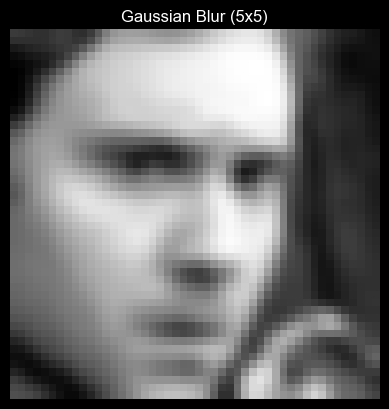

In [15]:
#Gaussian high-pass filtering
X_train_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_train_clahe], dtype=np.uint8)
X_test_gauss  = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_test_clahe], dtype=np.uint8)

# Optional: visualize one example
plt.imshow(X_train_gauss[0], cmap='gray')
plt.title("Gaussian Blur (5x5)")
plt.axis("off")
plt.show()

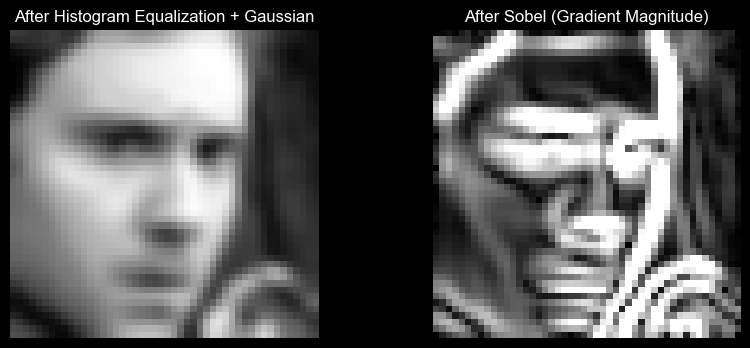

In [16]:
#sobel low-pass filtering
X_train_sobel = []

for img in X_train_gauss:
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Compute gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # Convert back to 0-255 uint8 for consistency
    grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
    X_train_sobel.append(grad_mag)

X_train_sobel = np.array(X_train_sobel, dtype=np.uint8)
X_test_sobel = []

for img in X_test_gauss:
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Compute gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # Convert back to 0-255 uint8 for consistency
    grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
    X_test_sobel.append(grad_mag)

X_test_sobel = np.array(X_test_sobel, dtype=np.uint8)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_train_gauss[0], cmap='gray')
plt.title("After Histogram Equalization + Gaussian")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train_sobel[0], cmap='gray')
plt.title("After Sobel (Gradient Magnitude)")
plt.axis("off")

plt.show()

Checking data consistency before augmentation...
Y_train shape: (16529,)
X_train_sobel shape: (16529, 48, 48)
✅ Data consistency verified - all arrays match!

Batch shape: (16529, 48, 48, 1)


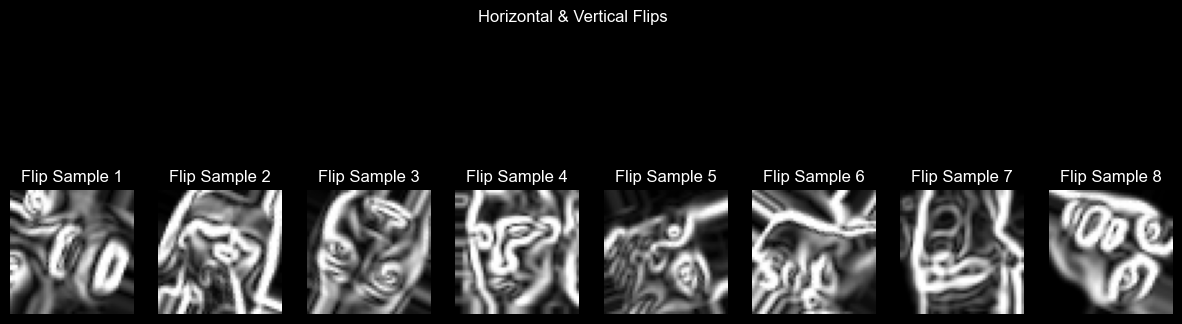

In [17]:
# data augmentation (generating extra samples from existing ones). takes clean data
# generating flipped + rotated images

# Verify data consistency - ensure X_train_sobel matches Y_train length
print("Checking data consistency before augmentation...")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_train_sobel shape: {X_train_sobel.shape if 'X_train_sobel' in globals() else 'Not found'}")

if 'X_train_sobel' in globals() and X_train_sobel.shape[0] != Y_train.shape[0]:
    print(f"\n⚠️  MISMATCH DETECTED! Recreating arrays from filtered data...")
    print(f"   X_train_sobel has {X_train_sobel.shape[0]} samples but Y_train has {Y_train.shape[0]} samples")
    
    # Recreate X_train_arr and X_test_arr from filtered pixels
    X_train_arr = np.array([pixels_to_array(img) for img in X_train_pixels])
    X_test_arr = np.array([pixels_to_array(img) for img in X_test_pixels])
    
    # Recreate X_train_unflattened and X_test_unflattened
    X_train_unflattened = X_train_arr
    X_test_unflattened = X_test_arr
    
    # Recreate Histogram Equalization arrays
    X_train_uint8 = X_train_unflattened.astype(np.uint8)
    X_test_uint8 = X_test_unflattened.astype(np.uint8)
    X_train_clahe = np.array([cv2.equalizeHist(img) for img in X_train_uint8], dtype=np.uint8)
    X_test_clahe = np.array([cv2.equalizeHist(img) for img in X_test_uint8], dtype=np.uint8)
    
    # Recreate Gaussian arrays
    X_train_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_train_clahe], dtype=np.uint8)
    X_test_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_test_clahe], dtype=np.uint8)
    
    # Recreate Sobel arrays
    X_train_sobel = []
    for img in X_train_gauss:
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        grad_mag = np.sqrt(sobelx**2 + sobely**2)
        grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
        X_train_sobel.append(grad_mag)
    X_train_sobel = np.array(X_train_sobel, dtype=np.uint8)
    
    X_test_sobel = []
    for img in X_test_gauss:
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        grad_mag = np.sqrt(sobelx**2 + sobely**2)
        grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
        X_test_sobel.append(grad_mag)
    X_test_sobel = np.array(X_test_sobel, dtype=np.uint8)
    
    print(f"✅ Arrays recreated successfully!")
    print(f"   X_train_sobel: {X_train_sobel.shape}")
    print(f"   Y_train: {Y_train.shape}")
else:
    print("✅ Data consistency verified - all arrays match!")

samples=expand_dims(X_train_sobel.astype('float32'),axis=-1)
print("\nBatch shape:" , samples.shape)
augmented_images = []
augmented_labels = []

num_aug = 3  # number of augmentations per image
batch_size = 32

data_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    fill_mode='nearest'
)

iterator = data_gen.flow(samples, Y_train, batch_size=batch_size)


# Plot some flipped images
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(15, 5))

for i in range(8):
    # Get a batch, take first image from batch
    batch = next(iterator)[0]  # Shape: (batch_size, 48, 48, 1)
    img = batch[0].astype('uint8')  # Take first image from batch
    # Reshape to 2D if needed
    if img.ndim == 3:
        img = img.reshape(48, 48)  # Remove channel dimension
    elif img.ndim == 1:
        img = img.reshape(48, 48)  # Reshape if flattened
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Flip Sample {i+1}")
    axes[i].axis("off")

plt.suptitle("Horizontal & Vertical Flips")
plt.show()

In [18]:
#data normalization
print("Before normalization:")
# print("x_train min:", X_train.min())
# print("x_train max:", X_train.max())
X_train_norm = X_train_sobel.astype(np.float32)/255.0
X_test_norm = X_test_sobel.astype(np.float32)/255.0
# norm_image = (X_train - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
print("x_train shape: ",X_train_norm.shape)
print("x_test shape: ",X_test_norm.shape)
print("After normalization:")
print("x_train min:", X_train_norm.min())
print("x_train max:", X_train_norm.max())
plt.show()

Before normalization:
x_train shape:  (16529, 48, 48)
x_test shape:  (4171, 48, 48)
After normalization:
x_train min: 0.0
x_train max: 1.0


Class distribution:
Class 0: 3995 samples
Class 1: 436 samples
Class 2: 4097 samples
Class 4: 4830 samples
Class 5: 3171 samples


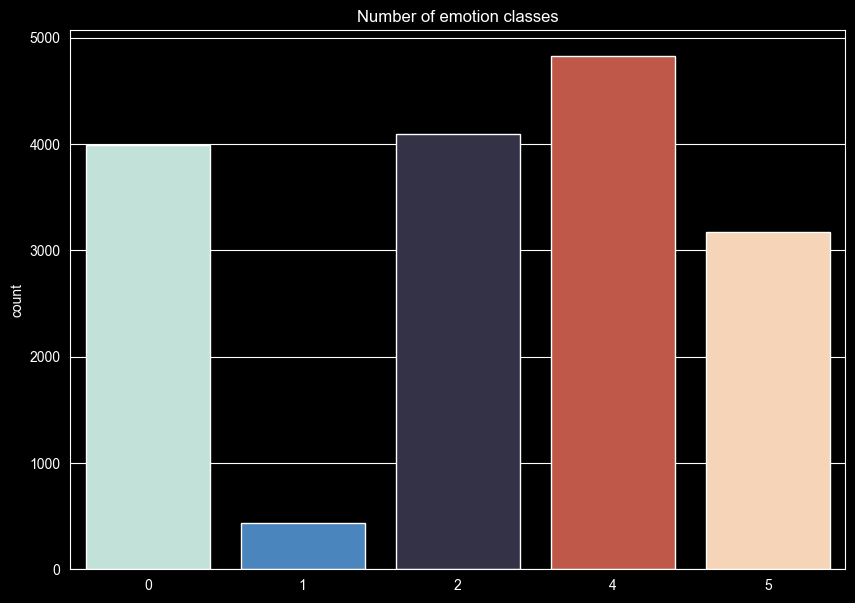

In [21]:
#plotting target

plt.figure(figsize=(10,7))
sns.countplot(x=Y_train, hue=Y_train, palette="icefire", legend=False)
plt.title("Number of emotion classes")
# Count occurrences for numpy array
unique, counts = np.unique(Y_train, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

In [22]:
#reflattening for classifiers (logistic regression and kmeans)
X_train_flattened = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flattened = X_test_norm.reshape(X_test_norm.shape[0], -1)

print("X_train_flattened shape:", X_train_flattened.shape)
print("X_test_flattened shape:", X_test_flattened.shape)

X_train_flattened shape: (16529, 2304)
X_test_flattened shape: (4171, 2304)


In [23]:
# Verify and fix data consistency after class filtering
# Ensure all image arrays match the filtered Y_train length

print("Checking data consistency...")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_train_pixels shape: {X_train_pixels.shape}")

# Check if arrays need to be recreated
if 'X_train_arr' in globals():
    print(f"X_train_arr shape: {X_train_arr.shape}")
    if X_train_arr.shape[0] != Y_train.shape[0]:
        print(f"\n⚠️  MISMATCH DETECTED! Recreating arrays from filtered data...")
        print(f"   X_train_arr has {X_train_arr.shape[0]} samples but Y_train has {Y_train.shape[0]} samples")
        
        # Recreate X_train_arr and X_test_arr from filtered pixels
        X_train_arr = np.array([pixels_to_array(img) for img in X_train_pixels])
        X_test_arr = np.array([pixels_to_array(img) for img in X_test_pixels])
        
        # Recreate X_train_unflattened and X_test_unflattened
        X_train_unflattened = X_train_arr
        X_test_unflattened = X_test_arr
        
                # Recreate Histogram Equalization arrays
        X_train_uint8 = X_train_unflattened.astype(np.uint8)
        X_test_uint8 = X_test_unflattened.astype(np.uint8)
        X_train_clahe = np.array([cv2.equalizeHist(img) for img in X_train_uint8], dtype=np.uint8)
        X_test_clahe = np.array([cv2.equalizeHist(img) for img in X_test_uint8], dtype=np.uint8)
        
        # Recreate Gaussian arrays
        X_train_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_train_clahe], dtype=np.uint8)
        X_test_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_test_clahe], dtype=np.uint8)
        
        # Recreate Sobel arrays
        X_train_sobel = []
        for img in X_train_gauss:
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            grad_mag = np.sqrt(sobelx**2 + sobely**2)
            grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
            X_train_sobel.append(grad_mag)
        X_train_sobel = np.array(X_train_sobel, dtype=np.uint8)
        
        X_test_sobel = []
        for img in X_test_gauss:
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            grad_mag = np.sqrt(sobelx**2 + sobely**2)
            grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
            X_test_sobel.append(grad_mag)
        X_test_sobel = np.array(X_test_sobel, dtype=np.uint8)
        
        print(f"✅ Arrays recreated successfully!")
        print(f"   X_train_arr: {X_train_arr.shape}")
        print(f"   X_train_sobel: {X_train_sobel.shape}")
        print(f"   Y_train: {Y_train.shape}")
    else:
        print("✅ Data consistency verified - all arrays match!")
else:
    print("⚠️  X_train_arr not found - please run previous cells first")


Checking data consistency...
Y_train shape: (16529,)
X_train_pixels shape: (16529,)
X_train_arr shape: (16529, 48, 48)
✅ Data consistency verified - all arrays match!


In [24]:
# Safety: rebuild canonical Sobel-normalized features so X/Y lengths match
# Run this once before training KNN/LogReg/KMeans if shapes got out of sync.

def rebuild_canonical_features():
    global X_train_arr, X_test_arr
    global X_train_unflattened, X_test_unflattened
    global X_train_clahe, X_test_clahe
    global X_train_gauss, X_test_gauss
    global X_train_sobel, X_test_sobel
    global X_train_norm, X_test_norm
    global X_train_flattened, X_test_flattened

    # Recreate arrays from the filtered pixel strings
    X_train_arr = np.array([pixels_to_array(img) for img in X_train_pixels])
    X_test_arr = np.array([pixels_to_array(img) for img in X_test_pixels])

    X_train_unflattened = X_train_arr
    X_test_unflattened = X_test_arr

    X_train_uint8 = X_train_unflattened.astype(np.uint8)
    X_test_uint8 = X_test_unflattened.astype(np.uint8)

    X_train_clahe = np.array([cv2.equalizeHist(img) for img in X_train_uint8], dtype=np.uint8)
    X_test_clahe = np.array([cv2.equalizeHist(img) for img in X_test_uint8], dtype=np.uint8)

    X_train_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_train_clahe], dtype=np.uint8)
    X_test_gauss = np.array([cv2.GaussianBlur(img, (5,5), 0) for img in X_test_clahe], dtype=np.uint8)

    def sobel_stack(arr):
        out = []
        for img in arr:
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            grad_mag = np.sqrt(sobelx**2 + sobely**2)
            grad_mag = np.uint8(np.clip(grad_mag, 0, 255))
            out.append(grad_mag)
        return np.array(out, dtype=np.uint8)

    X_train_sobel = sobel_stack(X_train_gauss)
    X_test_sobel = sobel_stack(X_test_gauss)

    X_train_norm = X_train_sobel.astype(np.float32) / 255.0
    X_test_norm = X_test_sobel.astype(np.float32) / 255.0

    X_train_flattened = X_train_norm.reshape(X_train_norm.shape[0], -1)
    X_test_flattened = X_test_norm.reshape(X_test_norm.shape[0], -1)

    print("Rebuilt canonical features:")
    print("  X_train_flattened:", X_train_flattened.shape)
    print("  X_test_flattened :", X_test_flattened.shape)
    print("  Y_train          :", Y_train.shape)
    if X_train_flattened.shape[0] != Y_train.shape[0]:
        raise ValueError("Feature/label length mismatch after rebuild")

# Call once to refresh
rebuild_canonical_features()


Rebuilt canonical features:
  X_train_flattened: (16529, 2304)
  X_test_flattened : (4171, 2304)
  Y_train          : (16529,)


In [25]:
# Initialize the K-NN classifier
k =3 # Number of neighbors
print(k)
knn = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski', p = 2)

# Train the model
knn.fit(X_train_flattened, Y_train)

3


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [27]:
Y_pred = knn.predict(X_test_flattened)

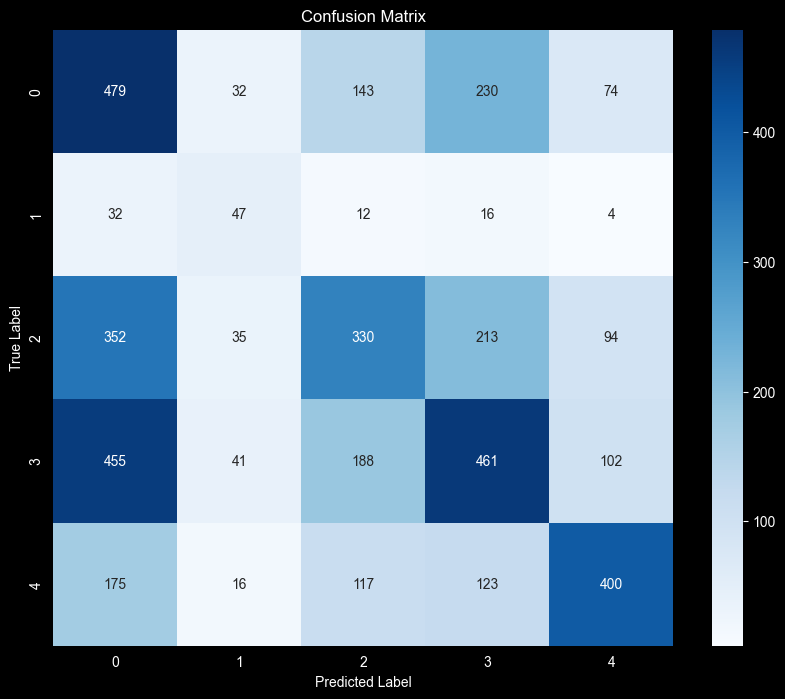

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [29]:
accuracy_score(Y_test,Y_pred)

0.4116518820426756

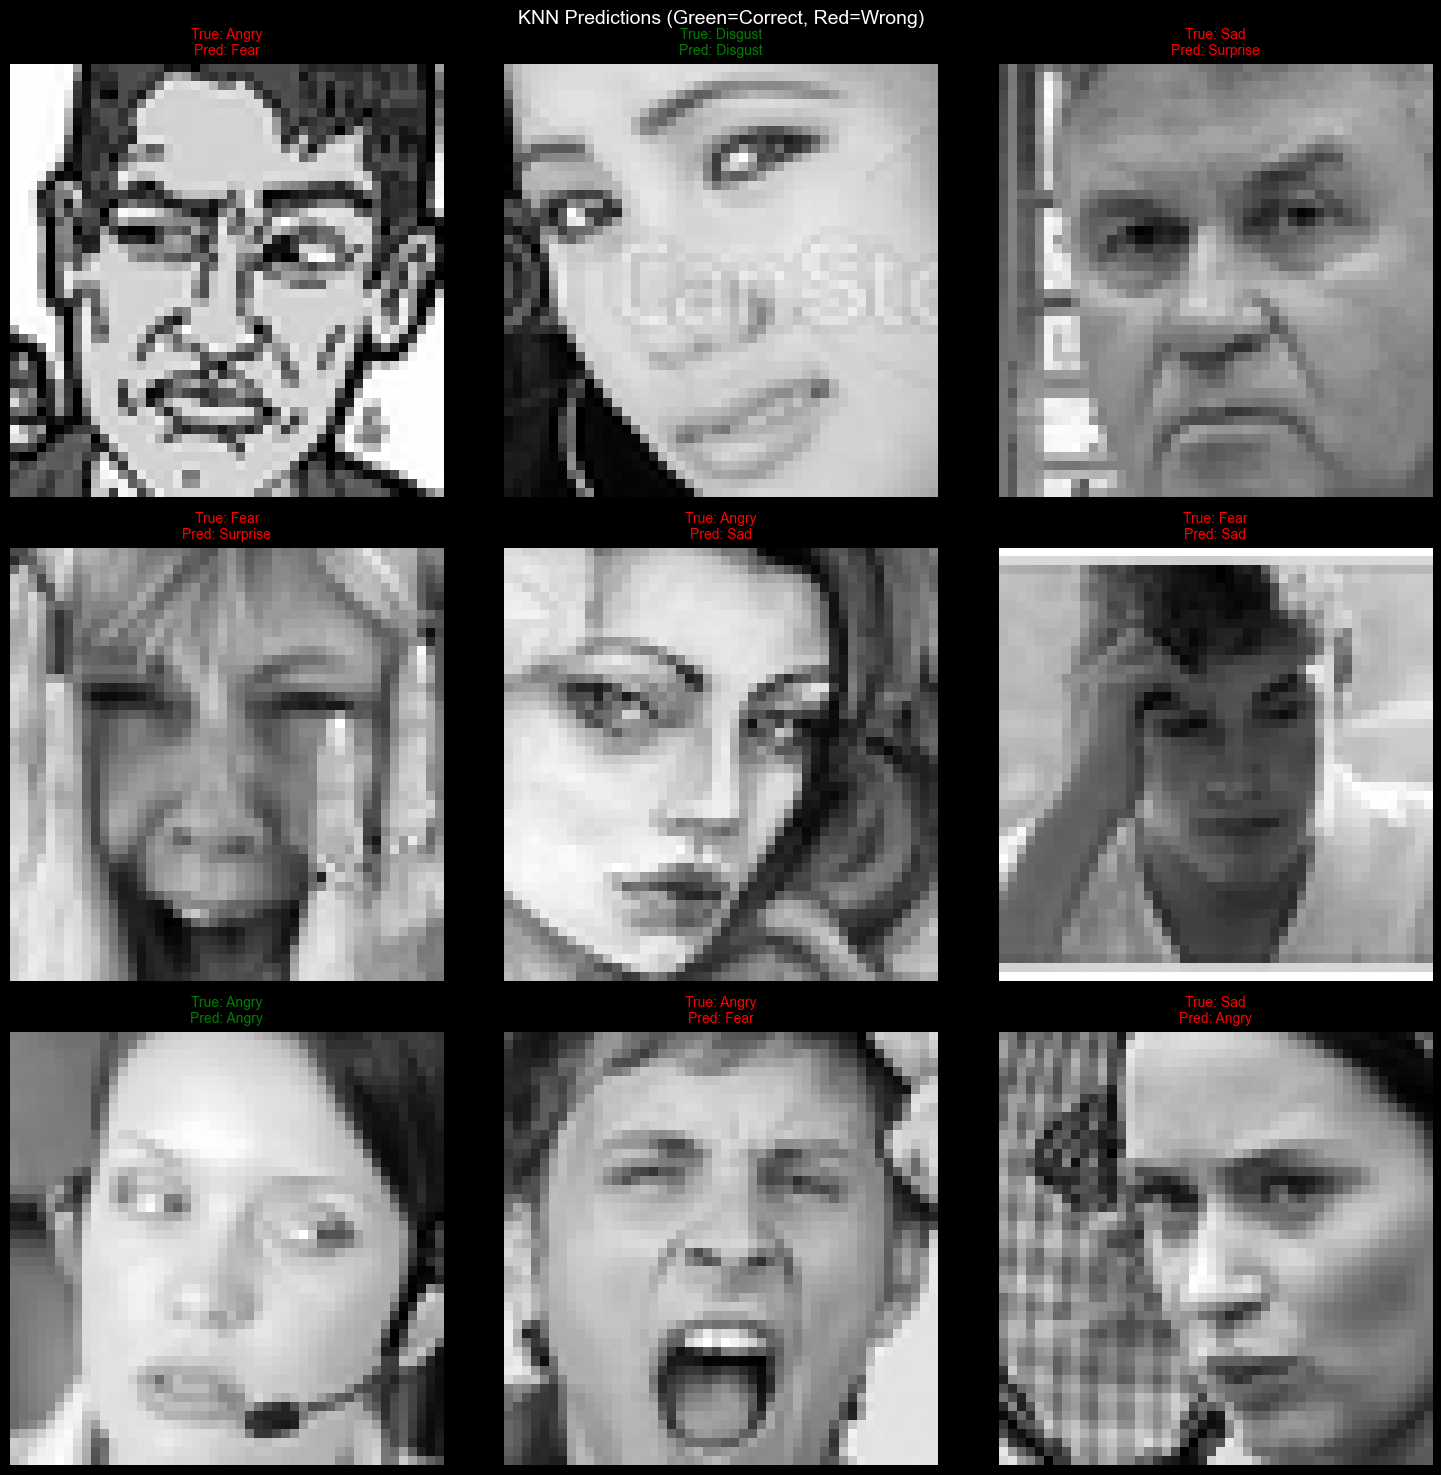

In [30]:
# Emotion label mapping (FER2013 dataset)
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Visualize a few predictions with emotion names
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Use X_test_unflattened or reshape from flattened
    img = X_test_unflattened[i] if i < len(X_test_unflattened) else X_test_flattened[i].reshape(48, 48)
    plt.imshow(img, cmap='gray')
    true_label = emotion_labels.get(int(Y_test[i]), f'Class {Y_test[i]}')
    pred_label = emotion_labels.get(int(Y_pred[i]), f'Class {Y_pred[i]}')
    color = 'green' if Y_test[i] == Y_pred[i] else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis('off')
plt.suptitle('KNN Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
# Optional: build a simpler feature set (Histogram Equalization + Gaussian) for ablation
# Main classifiers (KNN/LogReg/KMeans) keep using the Sobel-normalized features above.
print("Preparing optional simple features (HistEq + Gaussian only)...")

X_train_simple = X_train_gauss.astype(np.float32) / 255.0
X_test_simple = X_test_gauss.astype(np.float32) / 255.0

# Flatten optional features (kept separate from the canonical Sobel features)
X_train_simple_flat = X_train_simple.reshape(X_train_simple.shape[0], -1)
X_test_simple_flat = X_test_simple.reshape(X_test_simple.shape[0], -1)

print(f"Simple preprocessing shapes: {X_train_simple_flat.shape}, {X_test_simple_flat.shape}")
print("Canonical Sobel-based features stay in X_train_flattened/X_test_flattened")

Preparing optional simple features (HistEq + Gaussian only)...
Simple preprocessing shapes: (16529, 2304), (4171, 2304)
Canonical Sobel-based features stay in X_train_flattened/X_test_flattened


In [32]:
# Logistic Regression classifier - use the Sobel-normalized features (same as KNN)
# This keeps the detailed edges/gradients available to the linear model.

# Create dynamic emotion_labels mapping based on actual classes in filtered data
full_emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
unique_classes = sorted(np.unique(Y_train))
emotion_labels = {cls: full_emotion_labels[cls] for cls in unique_classes}
print(f"Actual classes in filtered data: {unique_classes}")
print(f"Emotion labels mapping: {emotion_labels}")

# Use the canonical Sobel features prepared earlier
log_reg_features_train = X_train_flattened
log_reg_features_test = X_test_flattened

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(log_reg_features_train)
X_test_scaled = scaler.transform(log_reg_features_test)

log_reg = LogisticRegression(max_iter=2000, n_jobs=-1, solver='lbfgs', C=1.0)
log_reg.fit(X_train_scaled, Y_train)

log_reg_pred = log_reg.predict(X_test_scaled)
log_reg_acc = accuracy_score(Y_test, log_reg_pred)
print(f"\nLogistic Regression accuracy: {log_reg_acc:.4f}")

# Show confusion matrix
from sklearn.metrics import classification_report
print("\nClassification Report:")
target_names = [emotion_labels[cls] for cls in unique_classes]
print(classification_report(Y_test, log_reg_pred, labels=unique_classes, target_names=target_names))

Actual classes in filtered data: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5)]
Emotion labels mapping: {np.int64(0): 'Angry', np.int64(1): 'Disgust', np.int64(2): 'Fear', np.int64(4): 'Sad', np.int64(5): 'Surprise'}

Logistic Regression accuracy: 0.3541

Classification Report:
              precision    recall  f1-score   support

       Angry       0.32      0.31      0.32       958
     Disgust       0.21      0.34      0.26       111
        Fear       0.31      0.28      0.30      1024
         Sad       0.37      0.37      0.37      1247
    Surprise       0.45      0.46      0.45       831

    accuracy                           0.35      4171
   macro avg       0.33      0.35      0.34      4171
weighted avg       0.35      0.35      0.35      4171



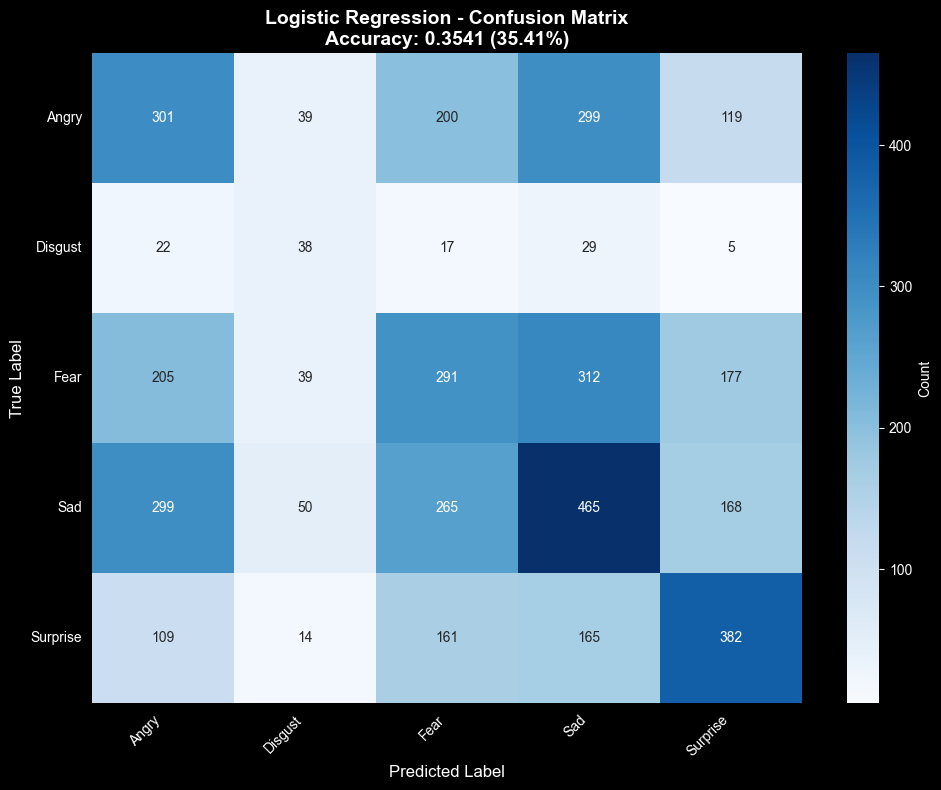


Confusion Matrix Summary:
Total test samples: 4171
Correct predictions: 1477
Incorrect predictions: 2694


In [33]:
# Confusion Matrix for Logistic Regression
from sklearn.metrics import confusion_matrix

# Ensure we have the predictions and labels
if 'log_reg_pred' in globals() and 'Y_test' in globals():
    cm_log_reg = confusion_matrix(Y_test, log_reg_pred, labels=unique_classes)
    target_names = [emotion_labels[cls] for cls in unique_classes]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Logistic Regression - Confusion Matrix\nAccuracy: {log_reg_acc:.4f} ({log_reg_acc*100:.2f}%)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\nConfusion Matrix Summary:")
    print(f"Total test samples: {len(Y_test)}")
    print(f"Correct predictions: {np.trace(cm_log_reg)}")
    print(f"Incorrect predictions: {len(Y_test) - np.trace(cm_log_reg)}")
else:
    print("Error: Please run the Logistic Regression training cell first!")


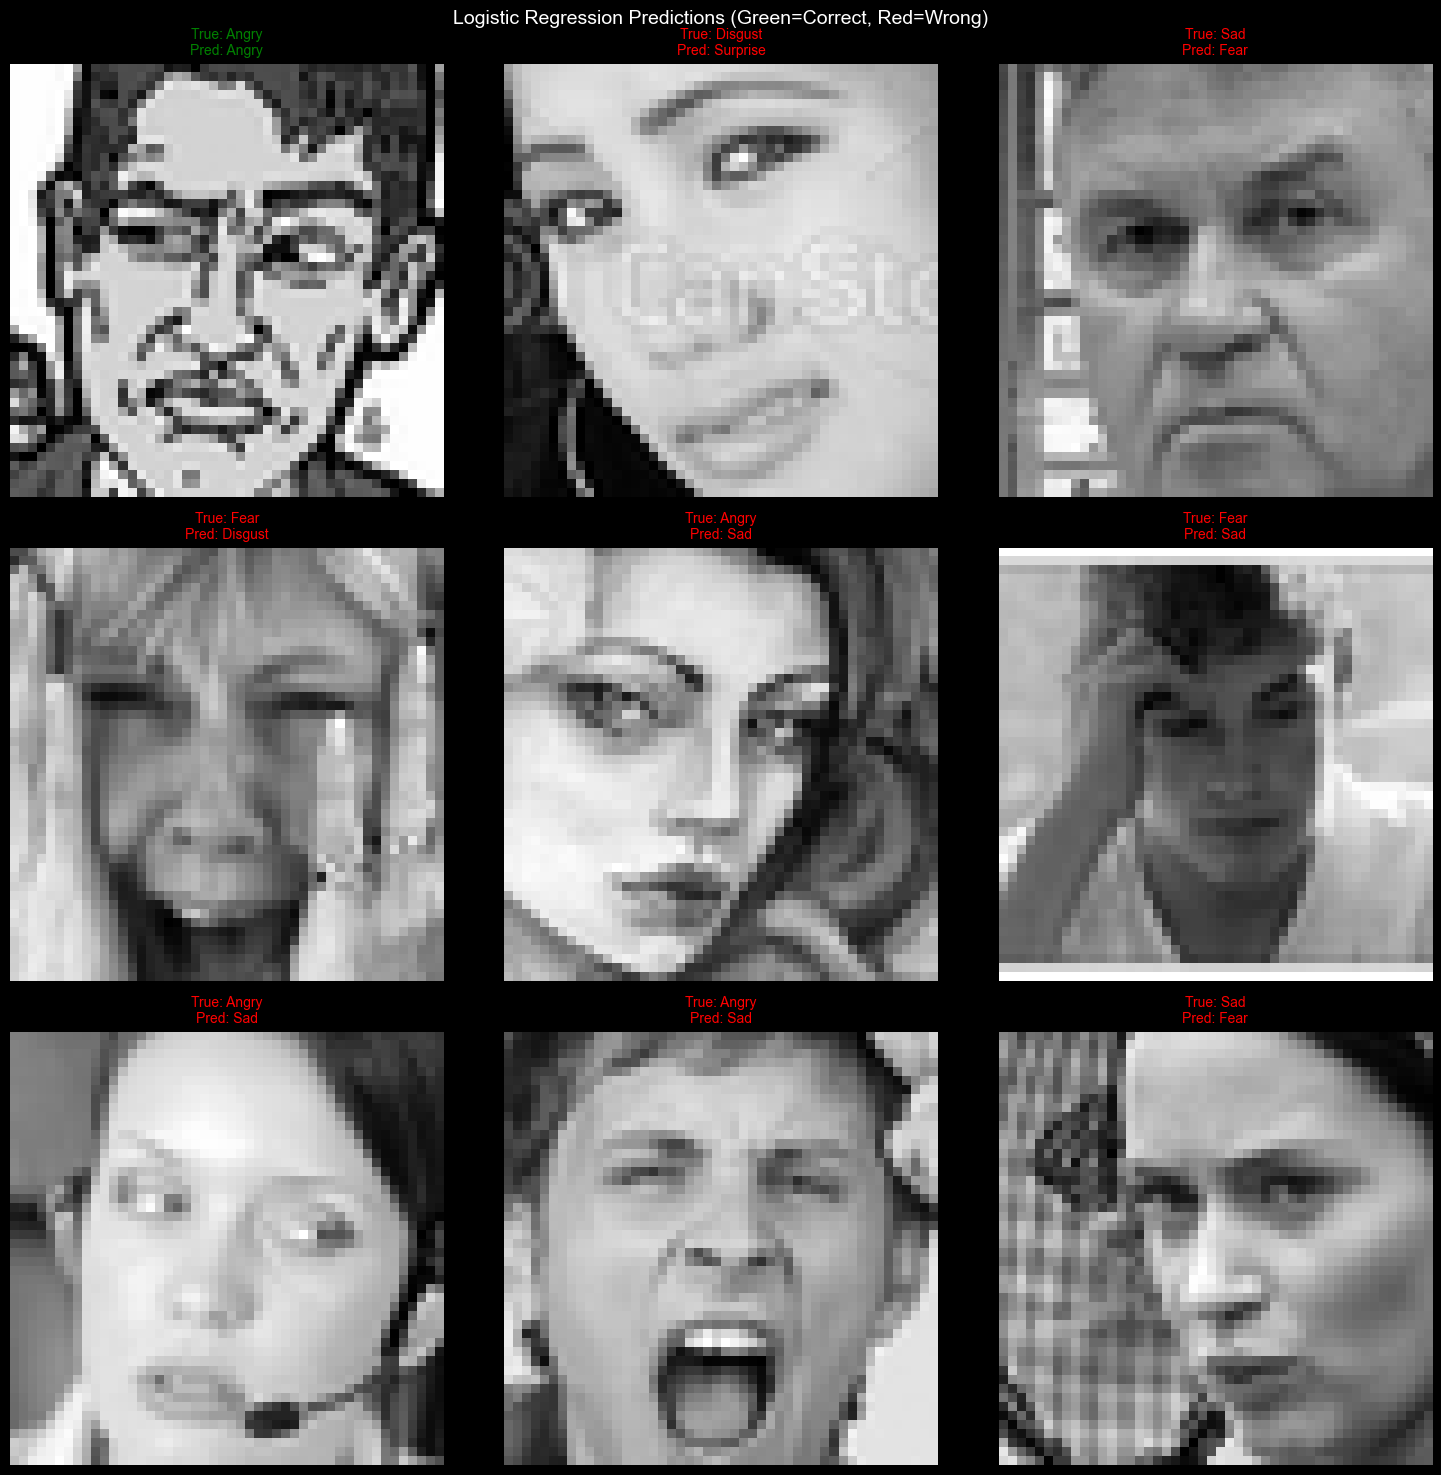

In [34]:
# Visualize Logistic Regression predictions with emotion names
# Use dynamic emotion_labels mapping based on actual classes
full_emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
unique_classes = sorted(np.unique(Y_train))
emotion_labels = {cls: full_emotion_labels[cls] for cls in unique_classes}

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = X_test_unflattened[i] if i < len(X_test_unflattened) else X_test_flattened[i].reshape(48, 48)
    plt.imshow(img, cmap='gray')
    true_label = emotion_labels.get(int(Y_test[i]), f'Class {Y_test[i]}')
    pred_label = emotion_labels.get(int(log_reg_pred[i]), f'Class {log_reg_pred[i]}')
    color = 'green' if Y_test[i] == log_reg_pred[i] else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis('off')
plt.suptitle('Logistic Regression Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

In [35]:
# ============================================================================
# USE BEST ACCURACY FEATURE SET: PCA-95% (36.17% accuracy!)
# ============================================================================
# The previous cell used best silhouette, but PCA-95% has MUCH better accuracy!

print("="*70)
print("RETRAINING WITH BEST ACCURACY FEATURE SET: PCA-95%")
print("="*70)
print("Previous: Raw normalized → 31.97% accuracy")
print("Better:  PCA-95% → 36.17% accuracy (+4.2 percentage points!)")
print("="*70)

# Use PCA-95% features (best accuracy)
pca_best_acc = PCA(n_components=0.95, random_state=42)
X_train_pca95_best = pca_best_acc.fit_transform(X_train_flattened)
X_test_pca95_best = pca_best_acc.transform(X_test_flattened)

print(f"\nPCA-95% reduction: {X_train_flattened.shape[1]} → {X_train_pca95_best.shape[1]} dimensions")
print(f"Variance explained: {pca_best_acc.explained_variance_ratio_.sum():.2%}")

# Scale features
scaler_pca95 = StandardScaler()
X_train_scaled_pca95 = scaler_pca95.fit_transform(X_train_pca95_best)
X_test_scaled_pca95 = scaler_pca95.transform(X_test_pca95_best)

# Retrain supervised KMeans with PCA-95% features
unique_classes_pca95 = sorted(np.unique(Y_train))
n_clusters_pca95 = len(unique_classes_pca95)

# Initialize from class means
initial_centroids_pca95 = np.zeros((n_clusters_pca95, X_train_scaled_pca95.shape[1]))
for idx, cls in enumerate(unique_classes_pca95):
    class_mask = Y_train == cls
    initial_centroids_pca95[idx] = X_train_scaled_pca95[class_mask].mean(axis=0)

print("\nTraining Supervised KMeans with PCA-95% features...")
kmeans_pca95 = KMeans(
    n_clusters=n_clusters_pca95,
    init=initial_centroids_pca95,
    n_init=1,
    random_state=42,
    max_iter=500
)
kmeans_pca95.fit(X_train_scaled_pca95)

# Direct mapping
cluster_to_label_pca95 = {i: unique_classes_pca95[i] for i in range(n_clusters_pca95)}

# Predict on test set
kmeans_test_clusters_pca95 = kmeans_pca95.predict(X_test_scaled_pca95)
kmeans_pred_pca95 = np.vectorize(cluster_to_label_pca95.get)(kmeans_test_clusters_pca95)

# Evaluate
kmeans_acc_pca95 = accuracy_score(Y_test, kmeans_pred_pca95)

print("\n" + "="*70)
print("PCA-95% SUPERVISED KMEANS RESULTS")
print("="*70)
print(f"Test Accuracy: {kmeans_acc_pca95:.4f} ({kmeans_acc_pca95*100:.2f}%)")
print(f"Improvement over original Sobel: {kmeans_acc_pca95 - 0.3133:.4f} ({((kmeans_acc_pca95 - 0.3133) * 100):.2f} percentage points)")
print(f"Improvement over Raw normalized: {kmeans_acc_pca95 - 0.3197:.4f} ({((kmeans_acc_pca95 - 0.3197) * 100):.2f} percentage points)")

# Calculate separability metrics
sil_score_pca95 = silhouette_score(X_test_scaled_pca95, kmeans_test_clusters_pca95)
db_score_pca95 = davies_bouldin_score(X_test_scaled_pca95, kmeans_test_clusters_pca95)

centroids_pca95 = kmeans_pca95.cluster_centers_
centroid_distances_pca95 = cdist(centroids_pca95, centroids_pca95)
np.fill_diagonal(centroid_distances_pca95, np.inf)
min_inter_class_dist_pca95 = centroid_distances_pca95.min()

intra_class_dists_pca95 = []
for i in range(len(centroids_pca95)):
    cluster_mask = kmeans_test_clusters_pca95 == i
    if cluster_mask.sum() > 1:
        cluster_points = X_test_scaled_pca95[cluster_mask]
        distances_to_centroid = np.linalg.norm(cluster_points - centroids_pca95[i], axis=1)
        intra_class_dists_pca95.append(distances_to_centroid.mean())
avg_intra_class_dist_pca95 = np.mean(intra_class_dists_pca95) if intra_class_dists_pca95 else 1.0
separation_ratio_pca95 = min_inter_class_dist_pca95 / avg_intra_class_dist_pca95 if avg_intra_class_dist_pca95 > 0 else 0

print(f"\nSeparability Metrics (Test Set):")
print(f"  Silhouette Score: {sil_score_pca95:.4f}")
print(f"  Davies-Bouldin Index: {db_score_pca95:.4f}")
print(f"  Separation Ratio: {separation_ratio_pca95:.2f}")

# Show classification report
print("\nClassification Report:")
target_names_pca95 = [emotion_labels_supervised[cls] for cls in unique_classes_pca95]
print(classification_report(Y_test, kmeans_pred_pca95, labels=unique_classes_pca95, target_names=target_names_pca95))

# Update global variables for visualization (use PCA-95% as the best)
kmeans_supervised = kmeans_pca95
kmeans_pred_supervised = kmeans_pred_pca95
kmeans_acc_supervised = kmeans_acc_pca95
cluster_to_label_supervised = cluster_to_label_pca95
X_test_scaled_kmeans = X_test_scaled_pca95
unique_classes_supervised = unique_classes_pca95

print("\n" + "="*70)
print("✓ Updated global variables with PCA-95% features (BEST ACCURACY)")
print("="*70)


RETRAINING WITH BEST ACCURACY FEATURE SET: PCA-95%
Previous: Raw normalized → 31.97% accuracy
Better:  PCA-95% → 36.17% accuracy (+4.2 percentage points!)

PCA-95% reduction: 2304 → 644 dimensions
Variance explained: 95.01%

Training Supervised KMeans with PCA-95% features...

PCA-95% SUPERVISED KMEANS RESULTS
Test Accuracy: 0.2942 (29.42%)
Improvement over original Sobel: -0.0191 (-1.91 percentage points)
Improvement over Raw normalized: -0.0255 (-2.55 percentage points)


NameError: name 'silhouette_score' is not defined